In [1]:
from __future__ import print_function
import keras
from keras.models import Sequential, Model, load_model
from keras import backend as K

import tensorflow as tf

import os
import pandas as pd

import numpy as np

import matplotlib.pyplot as plt
import matplotlib.cm as cm

#import aparent.visualization as vis

#from aparent_predictor import *


Using TensorFlow backend.


In [2]:
#Store variant prediction dataframe

variant_df = pd.read_csv('aparent_resnet_variant_predictions_polyadb_no_sequences_no_cutoff.csv', sep='\t')


In [3]:
#Load APADB Data and filter on targeted genes

#genes = ['RUNX1', 'CEBPA', 'GATA2', 'ANKRD26', 'DDX41', 'ETV6', 'PTEN', 'BRCA1', 'BRCA2', 'TP53', 'APC', 'ATM', 'PALB2', 'MSH2', 'MLH1', 'MSH6', 'PMS2', 'MUTYH']

polyadb_df = pd.read_csv('polyadb_processed.csv', sep=',')

#polyadb_df = polyadb_df.loc[polyadb_df['gene'].isin(genes)].reset_index(drop=True).copy()
polyadb_df = polyadb_df.loc[((~polyadb_df['gene'].isnull()) & (polyadb_df['gene'] != 'na')) & (polyadb_df['pas'] != -1)].reset_index(drop=True).copy()

print('len(polyadb_df) = ' + str(len(polyadb_df)))


len(polyadb_df) = 175451


In [4]:
#Process PolyaDB data

polyadb_df_minus = polyadb_df.query("strand == '-'").copy().reset_index(drop=True)
polyadb_df_plus = polyadb_df.query("strand == '+'").copy().reset_index(drop=True)

polyadb_df_minus = polyadb_df_minus.sort_values(by='pas_pos', ascending=False).copy().reset_index(drop=True)
polyadb_df_plus = polyadb_df_plus.sort_values(by='pas_pos', ascending=True).copy().reset_index(drop=True)

new_gene_id_list_plus = []
sitenum_list_plus = []
gene_id_dict = {}
for _, row in polyadb_df_plus.iterrows() :

    gene = row['gene']

    if gene not in gene_id_dict :
        gene_id_dict[gene] = 0

    gene_id_dict[gene] += 1

    new_gene_id_list_plus.append(gene + "." + str(gene_id_dict[gene]))
    sitenum_list_plus.append(gene_id_dict[gene])

polyadb_df_plus['gene_id'] = new_gene_id_list_plus
polyadb_df_plus['sitenum'] = sitenum_list_plus

new_gene_id_list_minus = []
sitenum_list_minus = []
gene_id_dict = {}
for _, row in polyadb_df_minus.iterrows() :

    gene = row['gene']

    if gene not in gene_id_dict :
        gene_id_dict[gene] = 0

    gene_id_dict[gene] += 1

    new_gene_id_list_minus.append(gene + "." + str(gene_id_dict[gene]))
    sitenum_list_minus.append(gene_id_dict[gene])

polyadb_df_minus['gene_id'] = new_gene_id_list_minus
polyadb_df_minus['sitenum'] = sitenum_list_minus

polyadb_df = pd.concat([polyadb_df_plus, polyadb_df_minus])

polyadb_df = polyadb_df.sort_values(by=['gene', 'sitenum'], ascending=True).reset_index(drop=True).copy()

In [5]:
#Get variant positions in hg38 coordinates

polyadb_bed_hg19 = pd.read_csv("polyadb_coordinates_utr3_hg19.bed", sep='\t', header=None, names=['chrom', 'pas_pos_hg19', 'end', 'gene', 'gene_id', 'strand'])
polyadb_bed_hg38 = pd.read_csv("polyadb_coordinates_utr3_hg38.bed", sep='\t', header=None, names=['chrom', 'pas_pos_hg38', 'end', 'gene', 'gene_id', 'strand'])

polyadb_bed_hg38 = polyadb_bed_hg38.join(polyadb_bed_hg19[['gene_id', 'pas_pos_hg19']].set_index('gene_id'), on='gene_id', how='inner').copy().reset_index(drop=True)

polyadb_bed_hg38['padb_join_id'] = polyadb_bed_hg38['chrom'] + "_" + polyadb_bed_hg38['pas_pos_hg19'].astype(str) + "_" + polyadb_bed_hg38['gene']
polyadb_df['padb_join_id'] = polyadb_df['chrom'] + "_" + polyadb_df['pas_pos'].astype(str) + "_" + polyadb_df['gene']

polyadb_df = polyadb_df.join(polyadb_bed_hg38[['padb_join_id', 'pas_pos_hg38']].set_index("padb_join_id"), on='padb_join_id', how='inner').copy().reset_index(drop=True)

polyadb_df = polyadb_df.query("site_type == '3_most_exon'")

polyadb_df = polyadb_df.drop_duplicates(subset=['gene_id'], keep='first').copy().reset_index(drop=True)

variant_df = variant_df.join(polyadb_df[['gene_id', 'pas_pos', 'pas_pos_hg38', 'sitenum', 'num_sites']].set_index("gene_id"), on='gene_id', how='inner').copy().reset_index(drop=True)

variant_df['var_position_hg38'] = variant_df['var_position'] - variant_df['pas_pos'] + variant_df['pas_pos_hg38']


In [6]:
#Get processed gnomAD v3 data

chrs = ['chr1', 'chr2', 'chr3', 'chr4', 'chr5', 'chr6', 'chr7', 'chr8', 'chr9', 'chr10', 'chr11', 'chr12', 'chr13', 'chr14', 'chr15', 'chr16', 'chr17', 'chr18', 'chr19', 'chr20', 'chr21', 'chr22', 'chrX', 'chrY']

gnomad_dfs = []
for chr_name in chrs :
    gnomad_dfs.append(pd.read_csv("apa_gnomad_v3/polyadb_gnomad_v3_" + chr_name + ".csv", sep='\t'))

gnomad_df = pd.concat(gnomad_dfs)

gnomad_df = gnomad_df.query("AC > 0").copy().reset_index(drop=True)

gnomad_df['POS'] = gnomad_df['POS'].astype(int) + 1


In [7]:
#Map variants to gnomAD

gnomad_df['gnomad_join_id'] = gnomad_df['CHROM'] + "_" + gnomad_df['POS'].astype(str) + "_" + gnomad_df['ALT']
variant_df['gnomad_join_id'] = variant_df['chrom'] + "_" + variant_df['var_position_hg38'].astype(str) + "_" + variant_df['var_nucleotide']

variant_df_gnomad = variant_df.join(gnomad_df[["gnomad_join_id", "AN", "AC", "AF"]].set_index("gnomad_join_id"), on='gnomad_join_id', how='inner').copy().reset_index(drop=True)

#variant_df_gnomad.to_csv("aparent_resnet_variant_predictions_polyadb_no_sequences_gnomad_no_cutoff_shifted.csv", sep='\t', index=False)


In [8]:

variant_df_gnomad = pd.read_csv("aparent_resnet_variant_predictions_polyadb_no_sequences_gnomad_no_cutoff_shifted.csv", sep='\t')


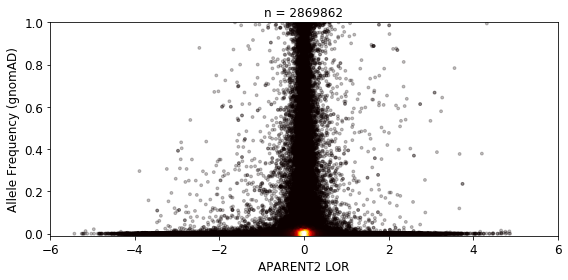

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

n_samples_for_kde = 1000

values = np.vstack([variant_df_gnomad['delta_logodds_0_205'].values[None, :], variant_df_gnomad['AF'].values[None, :]])

sample_index = np.arange(values.shape[1])
np.random.shuffle(sample_index)

kernel = stats.gaussian_kde(values[:, sample_index[:n_samples_for_kde]])(values)

fig = plt.figure(figsize=(8, 4))

plt.scatter(
    variant_df_gnomad['delta_logodds_0_205'].values,
    variant_df_gnomad['AF'].values,
    c=kernel,
    cmap="hot",
    s=8,
    alpha=0.25
)

#l1 = plt.axvline(x=-0.15, linewidth=3, color='lightcoral', label='|LOR| > 0.15')
#plt.axvline(x=0.15, linewidth=3, color='lightcoral')

plt.xlim(-6., 6.)
plt.ylim(-0.01, 1.)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.xlabel("APARENT2 LOR", fontsize=12)
plt.ylabel("Allele Frequency (gnomAD)", fontsize=12)

plt.title("n = " + str(len(variant_df_gnomad)), fontsize=12)

#plt.legend(handles=[l1], fontsize=12)

plt.tight_layout()

plt.savefig("apa_gnomAD_LOR_vs_AF.eps")
plt.savefig("apa_gnomAD_LOR_vs_AF.png", dpi=300, transparent=True)

plt.show()


Wilcoxon statistic = 7.7885
P-value = 6.783336734486849e-15
n1 / n2 = 806961 / 62086
AF threshold = 0.001


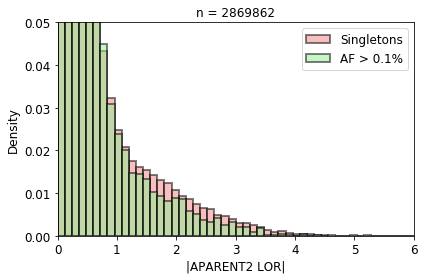

In [10]:
from scipy.stats import ttest_ind, ranksums

f = plt.figure(figsize=(6, 4))

x = np.abs(variant_df_gnomad.query("delta_logodds_0_205 < 0.")['delta_logodds_0_205'])
y = variant_df_gnomad.query("delta_logodds_0_205 < 0.")['AF']
ac = variant_df_gnomad.query("delta_logodds_0_205 < 0.")['AC']

ac_thresh_low = 1
af_thresh_high = 0.001
x_thresh = 6.
x_min = 0.

x1 = x[(ac <= ac_thresh_low) & (x <= x_thresh)]
x2 = x[(y > af_thresh_high) & (x <= x_thresh)]

s, p = ranksums(x1, x2)

print("Wilcoxon statistic = " + str(round(s, 4)))
print("P-value = " + str(p))
print("n1 / n2 = " + str(x1.shape[0]) + " / " + str(x2.shape[0]))
print("AF threshold = " + str(round(af_thresh_high, 4)))

x1_hist, bin_edges = np.histogram(x1, range=(x_min, x_thresh), bins=50, density=True)
x2_hist, _ = np.histogram(x2, range=(x_min, x_thresh), bins=50, density=True)

bin_width = bin_edges[1] - bin_edges[0]

plt.bar(bin_edges[:-1] + bin_width/2., x1_hist, width=bin_width, color='lightcoral', alpha=0.5, linewidth=2, edgecolor='black', label='Singletons')
plt.bar(bin_edges[:-1] + bin_width/2., x2_hist, width=bin_width, color='lightgreen', alpha=0.5, linewidth=2, edgecolor='black', label='AF > ' + str(af_thresh_high * 100) + '%')

plt.xlim(x_min, x_thresh)
plt.ylim(0., 0.05)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.xlabel("|APARENT2 LOR|", fontsize=12)
plt.ylabel("Density", fontsize=12)

plt.title("n = " + str(len(variant_df_gnomad)), fontsize=12)

plt.legend(fontsize=12)

plt.tight_layout()

plt.savefig("apa_gnomAD_LOR_vs_AF_histo_only_neg.eps")
plt.savefig("apa_gnomAD_LOR_vs_AF_histo_only_neg.png", dpi=300, transparent=True)

plt.show()


Wilcoxon statistic = -19.8207
P-value = 1.9735486456133608e-87
n1 / n2 = 1515940 / 122847
AF threshold = 0.001


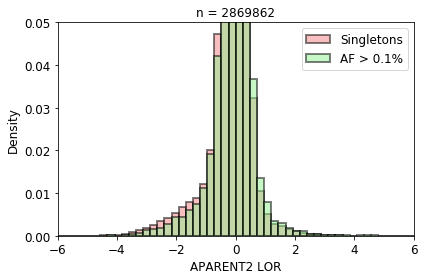

In [11]:
from scipy.stats import ttest_ind, ranksums

f = plt.figure(figsize=(6, 4))

x = variant_df_gnomad['delta_logodds_0_205']
y = variant_df_gnomad['AF']
ac = variant_df_gnomad['AC']

ac_thresh_low = 1
af_thresh_high = 0.001
x_thresh = 6.
x_min = -x_thresh

x1 = x[(ac <= ac_thresh_low) & (x <= x_thresh)]
x2 = x[(y > af_thresh_high) & (x <= x_thresh)]

s, p = ranksums(x1, x2)

print("Wilcoxon statistic = " + str(round(s, 4)))
print("P-value = " + str(p))
print("n1 / n2 = " + str(x1.shape[0]) + " / " + str(x2.shape[0]))
print("AF threshold = " + str(round(af_thresh_high, 4)))

x1_hist, bin_edges = np.histogram(x1, range=(x_min, x_thresh), bins=50, density=True)
x2_hist, _ = np.histogram(x2, range=(x_min, x_thresh), bins=50, density=True)

bin_width = bin_edges[1] - bin_edges[0]

plt.bar(bin_edges[:-1] + bin_width/2., x1_hist, width=bin_width, color='lightcoral', alpha=0.5, linewidth=2, edgecolor='black', label='Singletons')
plt.bar(bin_edges[:-1] + bin_width/2., x2_hist, width=bin_width, color='lightgreen', alpha=0.5, linewidth=2, edgecolor='black', label='AF > ' + str(af_thresh_high * 100) + '%')

plt.xlim(x_min, x_thresh)
plt.ylim(0., 0.05)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.xlabel("APARENT2 LOR", fontsize=12)
plt.ylabel("Density", fontsize=12)

plt.title("n = " + str(len(variant_df_gnomad)), fontsize=12)

plt.legend(fontsize=12)

plt.tight_layout()

plt.savefig("apa_gnomAD_LOR_vs_AF_histo.eps")
plt.savefig("apa_gnomAD_LOR_vs_AF_histo.png", dpi=300, transparent=True)

plt.show()


In [9]:

variant_df_gnomad['rel_var_position'] = -1
variant_df_gnomad.loc[variant_df_gnomad['strand'] == '+', 'rel_var_position'] = variant_df_gnomad['var_position'] - (variant_df_gnomad['pas_pos'] - 70 + 1)
variant_df_gnomad.loc[variant_df_gnomad['strand'] == '-', 'rel_var_position'] = ((variant_df_gnomad['pas_pos'] - (205 - 70)) + 205) - variant_df_gnomad['var_position']


r = -0.014440082250103512
p = 3.5952375326884803e-132
n = 2869862


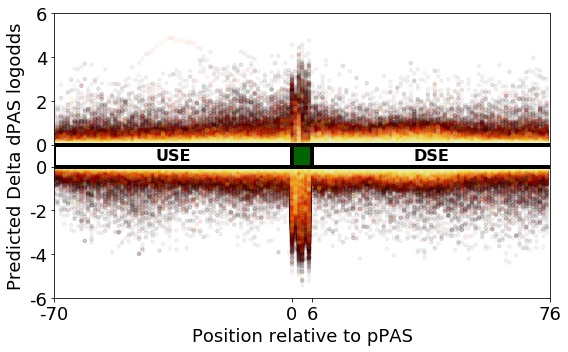

In [13]:
import matplotlib.cm as cm
import matplotlib.colors as colors

import matplotlib as mpl
from matplotlib.text import TextPath
from matplotlib.patches import PathPatch, Rectangle
from matplotlib.font_manager import FontProperties
from matplotlib import gridspec
from matplotlib.ticker import FormatStrFormatter

from scipy.stats import spearmanr, ttest_ind

df = variant_df_gnomad.copy()

fig_name = 'apa_gnomAD_LOR_pos_scatter'

snv_pos_column = 'rel_var_position'
pred_column = 'delta_logodds_0_205'
p_val_column = 'AF'

sort_pred = True
show_stats = False
color_by_p_val = True

fig = plt.figure(figsize=(8, 5))

annotation_height = 1.0

border_eta = 0.00

dot_size=12
dot_alpha=0.05

snv_pos = np.ravel(df[snv_pos_column].values) - 70
p_val_true = np.log(np.clip(df[p_val_column].values, 1e-7, 1. - 1e-7)) / np.log(10.)
delta_logodds_pred = np.ravel(df[pred_column].values)

vmin = np.quantile(p_val_true, q=0.50)
vmax = np.quantile(p_val_true, q=1.00)

r_val, p_val = spearmanr(np.abs(delta_logodds_pred), p_val_true)

print("r = " + str(r_val))
print("p = " + str(p_val))

n_points = len(df)

if sort_pred :
    sort_index = np.argsort(np.abs(p_val_true))[::-1]
    snv_pos = snv_pos[sort_index]
    p_val_true = p_val_true[sort_index]
    delta_logodds_pred = delta_logodds_pred[sort_index]

delta_logodds_pred[delta_logodds_pred < 0.0] -= annotation_height
ax = plt.gca()
ax.add_patch(Rectangle((-70 + border_eta, -annotation_height + border_eta), 70 - 2.*border_eta, annotation_height - 2.*border_eta, fill=True, facecolor='white', edgecolor='black', lw=4))
ax.add_patch(Rectangle((0 + border_eta, -annotation_height + border_eta), 6 - 2.*border_eta, annotation_height - 2.*border_eta, fill=True, facecolor='darkgreen', edgecolor='black', lw=4))
ax.add_patch(Rectangle((6 + border_eta, -annotation_height + border_eta), 76 - 2.*border_eta, annotation_height - 2.*border_eta, fill=True, facecolor='white', edgecolor='black', lw=4))

use_start = -70
use_end = 0
if use_end - use_start > 10 :
    ax.text(use_start + (use_end - use_start) / 2., -annotation_height/2., 'USE', horizontalalignment='center', verticalalignment='center', color='black', fontsize=16, weight="bold")

dse_start = 6
dse_end = 76
if dse_end - dse_start > 10 :
    ax.text(dse_start + (dse_end - dse_start) / 2., -annotation_height/2., 'DSE', horizontalalignment='center', verticalalignment='center', color='black', fontsize=16, weight="bold")

if color_by_p_val :
    plt.scatter(snv_pos, delta_logodds_pred, c=p_val_true, cmap="hot", vmin=vmin, vmax=vmax, alpha=dot_alpha, s=dot_size)
else :
    plt.scatter(snv_pos, delta_logodds_pred, c='black', vmin=vmin, vmax=vmax, alpha=dot_alpha, s=dot_size)

annot_text = 'n = ' + str(n_points)

print(annot_text)

if show_stats :
    ax = plt.gca()
    ax.text(0.95, 0.90, annot_text, horizontalalignment='right', verticalalignment='bottom', transform=ax.transAxes, color='black', fontsize=16, weight="bold")

plt.xticks([use_start, 0, 6, dse_end], [use_start, 0, 6, dse_end], fontsize=18)
plt.yticks([-7, -5, -3, -1, 0, 2, 4, 6], [-6, -4, -2, 0, 0, 2, 4, 6], fontsize=18)

plt.xlabel('Position relative to pPAS', fontsize=18)
plt.ylabel('Predicted Delta dPAS logodds', fontsize=18)

plt.xlim(use_start, dse_end)
plt.ylim(-7, 6)

plt.tight_layout()

if fig_name is not None :
    plt.savefig(fig_name + '.png', dpi=600, transparent=True)
    plt.savefig(fig_name + '.eps')

plt.show()


r = -0.012578038603157869
p = 9.393515557195143e-101
n = 2869862


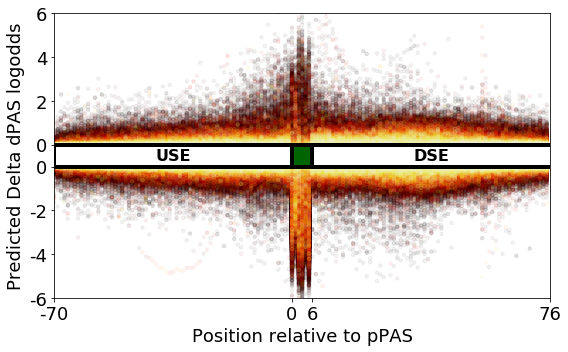

In [14]:
import matplotlib.cm as cm
import matplotlib.colors as colors

import matplotlib as mpl
from matplotlib.text import TextPath
from matplotlib.patches import PathPatch, Rectangle
from matplotlib.font_manager import FontProperties
from matplotlib import gridspec
from matplotlib.ticker import FormatStrFormatter

from scipy.stats import spearmanr, ttest_ind

df = variant_df_gnomad.copy()

fig_name = 'apa_gnomAD_LOR_77_127_pos_scatter'

snv_pos_column = 'rel_var_position'
pred_column = 'delta_logodds_77_127'
p_val_column = 'AF'

sort_pred = True
show_stats = False
color_by_p_val = True

fig = plt.figure(figsize=(8, 5))

annotation_height = 1.0

border_eta = 0.00

dot_size=12
dot_alpha=0.05

snv_pos = np.ravel(df[snv_pos_column].values) - 70
p_val_true = np.log(np.clip(df[p_val_column].values, 1e-7, 1. - 1e-7)) / np.log(10.)
delta_logodds_pred = np.ravel(df[pred_column].values)

vmin = np.quantile(p_val_true, q=0.50)
vmax = np.quantile(p_val_true, q=1.00)

r_val, p_val = spearmanr(np.abs(delta_logodds_pred), p_val_true)

print("r = " + str(r_val))
print("p = " + str(p_val))

n_points = len(df)

if sort_pred :
    sort_index = np.argsort(np.abs(p_val_true))[::-1]
    snv_pos = snv_pos[sort_index]
    p_val_true = p_val_true[sort_index]
    delta_logodds_pred = delta_logodds_pred[sort_index]

delta_logodds_pred[delta_logodds_pred < 0.0] -= annotation_height
ax = plt.gca()
ax.add_patch(Rectangle((-70 + border_eta, -annotation_height + border_eta), 70 - 2.*border_eta, annotation_height - 2.*border_eta, fill=True, facecolor='white', edgecolor='black', lw=4))
ax.add_patch(Rectangle((0 + border_eta, -annotation_height + border_eta), 6 - 2.*border_eta, annotation_height - 2.*border_eta, fill=True, facecolor='darkgreen', edgecolor='black', lw=4))
ax.add_patch(Rectangle((6 + border_eta, -annotation_height + border_eta), 76 - 2.*border_eta, annotation_height - 2.*border_eta, fill=True, facecolor='white', edgecolor='black', lw=4))

use_start = -70
use_end = 0
if use_end - use_start > 10 :
    ax.text(use_start + (use_end - use_start) / 2., -annotation_height/2., 'USE', horizontalalignment='center', verticalalignment='center', color='black', fontsize=16, weight="bold")

dse_start = 6
dse_end = 76
if dse_end - dse_start > 10 :
    ax.text(dse_start + (dse_end - dse_start) / 2., -annotation_height/2., 'DSE', horizontalalignment='center', verticalalignment='center', color='black', fontsize=16, weight="bold")

if color_by_p_val :
    plt.scatter(snv_pos, delta_logodds_pred, c=p_val_true, cmap="hot", vmin=vmin, vmax=vmax, alpha=dot_alpha, s=dot_size)
else :
    plt.scatter(snv_pos, delta_logodds_pred, c='black', vmin=vmin, vmax=vmax, alpha=dot_alpha, s=dot_size)

annot_text = 'n = ' + str(n_points)

print(annot_text)

if show_stats :
    ax = plt.gca()
    ax.text(0.95, 0.90, annot_text, horizontalalignment='right', verticalalignment='bottom', transform=ax.transAxes, color='black', fontsize=16, weight="bold")

plt.xticks([use_start, 0, 6, dse_end], [use_start, 0, 6, dse_end], fontsize=18)
plt.yticks([-7, -5, -3, -1, 0, 2, 4, 6], [-6, -4, -2, 0, 0, 2, 4, 6], fontsize=18)

plt.xlabel('Position relative to pPAS', fontsize=18)
plt.ylabel('Predicted Delta dPAS logodds', fontsize=18)

plt.xlim(use_start, dse_end)
plt.ylim(-7, 6)

plt.tight_layout()

if fig_name is not None :
    plt.savefig(fig_name + '.png', dpi=600, transparent=True)
    plt.savefig(fig_name + '.eps')

plt.show()


In [10]:

variant_df_gnomad['alt_usage'] = 1. / (1. + 1. / ((np.clip(variant_df_gnomad['native_usage'], 1e-7, 1. - 1e-7) / (1. - np.clip(variant_df_gnomad['native_usage'], 1e-7, 1. - 1e-7))) * np.exp(variant_df_gnomad['delta_logodds_0_205'])))
variant_df_gnomad['delta_usage'] = variant_df_gnomad['alt_usage'] - variant_df_gnomad['native_usage']


In [11]:

variant_df_gnomad['alt_usage_77_127'] = 1. / (1. + 1. / ((np.clip(variant_df_gnomad['native_usage'], 1e-7, 1. - 1e-7) / (1. - np.clip(variant_df_gnomad['native_usage'], 1e-7, 1. - 1e-7))) * np.exp(variant_df_gnomad['delta_logodds_77_127'])))
variant_df_gnomad['delta_usage_77_127'] = variant_df_gnomad['alt_usage_77_127'] - variant_df_gnomad['native_usage']


In [12]:

variant_df['alt_usage'] = 1. / (1. + 1. / ((np.clip(variant_df['native_usage'], 1e-7, 1. - 1e-7) / (1. - np.clip(variant_df['native_usage'], 1e-7, 1. - 1e-7))) * np.exp(variant_df['delta_logodds_0_205'])))
variant_df['delta_usage'] = variant_df['alt_usage'] - variant_df['native_usage']


In [13]:

variant_df['alt_usage_77_127'] = 1. / (1. + 1. / ((np.clip(variant_df['native_usage'], 1e-7, 1. - 1e-7) / (1. - np.clip(variant_df['native_usage'], 1e-7, 1. - 1e-7))) * np.exp(variant_df['delta_logodds_77_127'])))
variant_df['delta_usage_77_127'] = variant_df['alt_usage_77_127'] - variant_df['native_usage']


In [14]:

variant_df['rel_var_position'] = -1
variant_df.loc[variant_df['strand'] == '+', 'rel_var_position'] = variant_df['var_position'] - (variant_df['pas_pos'] - 70 + 1)
variant_df.loc[variant_df['strand'] == '-', 'rel_var_position'] = ((variant_df['pas_pos'] - (205 - 70)) + 205) - variant_df['var_position']


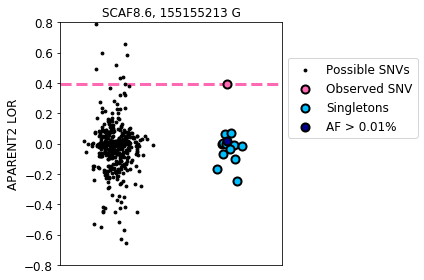

In [37]:
import seaborn as sns

gene_id = 'SCAF8.6'
var_position = 155155213
var_nucleotide = 'G'

var_logodds = variant_df.query("gene_id == '" + gene_id + "' and var_position == " + str(var_position) + " and var_nucleotide == '" + str(var_nucleotide) + "'").iloc[0]['delta_logodds_0_205']

all_logodds = variant_df.query("gene_id == '" + gene_id + "' and (rel_var_position < 70 or rel_var_position >= 76)")['delta_logodds_0_205'].values

gnomad_logodds = variant_df_gnomad.query("gene_id == '" + gene_id + "'")['delta_logodds_0_205'].values
gnomad_logodds_singletons = variant_df_gnomad.query("gene_id == '" + gene_id + "' and AC == 1")['delta_logodds_0_205'].values
gnomad_logodds_0_0001 = variant_df_gnomad.query("gene_id == '" + gene_id + "' and AC > 1 and AF >= 0.0001 and AF < 0.001")['delta_logodds_0_205'].values
gnomad_logodds_0_001 = variant_df_gnomad.query("gene_id == '" + gene_id + "' and AC > 1 and AF >= 0.001 and AF < 0.01")['delta_logodds_0_205'].values
gnomad_logodds_0_01 = variant_df_gnomad.query("gene_id == '" + gene_id + "' and AC > 1 and AF >= 0.01 and AF < 0.1")['delta_logodds_0_205'].values
gnomad_logodds_0_1 = variant_df_gnomad.query("gene_id == '" + gene_id + "' and AC > 1 and AF >= 0.1")['delta_logodds_0_205'].values

f = plt.figure(figsize=(6, 4))

plt.scatter(np.random.normal(1., 0.1, size=(all_logodds.shape[0])), all_logodds, color='black', s=8, label='Possible SNVs')
if len(variant_df_gnomad.query("gene_id == '" + gene_id + "' and var_position == " + str(var_position) + " and var_nucleotide == '" + str(var_nucleotide) + "'")) == 0 :
    plt.scatter([2.], np.array([var_logodds]), color='hotpink', s=65, edgecolor='black', linewidth=2, label='Observed SNV')

plt.axhline(y=np.array([var_logodds]), color='hotpink', linestyle='--', linewidth=3, zorder=0)

plt.scatter(np.random.normal(2., 0.1, size=(gnomad_logodds_singletons.shape[0])), gnomad_logodds_singletons, color='deepskyblue', s=65, edgecolor='black', linewidth=2, label='Singletons')
if gnomad_logodds_0_0001.shape[0] > 0 :
    plt.scatter(np.random.normal(2., 0.1, size=(gnomad_logodds_0_0001.shape[0])), gnomad_logodds_0_0001, color='darkblue', s=65, edgecolor='black', linewidth=2, label='AF > 0.01%')
if gnomad_logodds_0_001.shape[0] > 0 :
    plt.scatter(np.random.normal(2., 0.1, size=(gnomad_logodds_0_001.shape[0])), gnomad_logodds_0_001, color='orange', s=65, edgecolor='black', linewidth=2, label='AF > 0.1%')
if gnomad_logodds_0_01.shape[0] > 0 :
    plt.scatter(np.random.normal(2., 0.1, size=(gnomad_logodds_0_01.shape[0])), gnomad_logodds_0_01, color='darkviolet', s=65, edgecolor='black', linewidth=2, label='AF > 1%')
if gnomad_logodds_0_1.shape[0] > 0 :
    plt.scatter(np.random.normal(2., 0.1, size=(gnomad_logodds_0_1.shape[0])), gnomad_logodds_0_1, color='rebeccapurple', s=65, edgecolor='black', linewidth=2, label='AF > 10%')

plt.xlim(0.5, 2.5)
plt.ylim(-0.8, 0.8)

plt.yticks(fontsize=12)
plt.xticks([], [])

plt.ylabel("APARENT2 LOR", fontsize=12)

plt.title(gene_id + ", " + str(var_position) + " " + var_nucleotide, fontsize=12)

plt.legend(fontsize=12, loc='lower left', bbox_to_anchor=(1, 0.5))

plt.tight_layout()

plt.savefig("apa_gnomAD_example_" + gene_id + "_" + str(var_position) + "_" + str(var_nucleotide) + ".eps")
plt.savefig("apa_gnomAD_example_" + gene_id + "_" + str(var_position) + "_" + str(var_nucleotide) + ".png", dpi=300, transparent=True)

plt.show()


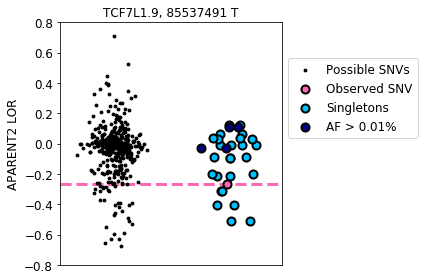

In [45]:
import seaborn as sns

gene_id = 'TCF7L1.9'
var_position = 85537491
var_nucleotide = 'T'

var_logodds = variant_df.query("gene_id == '" + gene_id + "' and var_position == " + str(var_position) + " and var_nucleotide == '" + str(var_nucleotide) + "'").iloc[0]['delta_logodds_0_205']

all_logodds = variant_df.query("gene_id == '" + gene_id + "' and (rel_var_position < 70 or rel_var_position >= 76)")['delta_logodds_0_205'].values

gnomad_logodds = variant_df_gnomad.query("gene_id == '" + gene_id + "'")['delta_logodds_0_205'].values
gnomad_logodds_singletons = variant_df_gnomad.query("gene_id == '" + gene_id + "' and AC == 1")['delta_logodds_0_205'].values
gnomad_logodds_0_0001 = variant_df_gnomad.query("gene_id == '" + gene_id + "' and AC > 1 and AF >= 0.0001 and AF < 0.001")['delta_logodds_0_205'].values
gnomad_logodds_0_001 = variant_df_gnomad.query("gene_id == '" + gene_id + "' and AC > 1 and AF >= 0.001 and AF < 0.01")['delta_logodds_0_205'].values
gnomad_logodds_0_01 = variant_df_gnomad.query("gene_id == '" + gene_id + "' and AC > 1 and AF >= 0.01 and AF < 0.1")['delta_logodds_0_205'].values
gnomad_logodds_0_1 = variant_df_gnomad.query("gene_id == '" + gene_id + "' and AC > 1 and AF >= 0.1")['delta_logodds_0_205'].values

f = plt.figure(figsize=(6, 4))

plt.scatter(np.random.normal(1., 0.1, size=(all_logodds.shape[0])), all_logodds, color='black', s=8, label='Possible SNVs')
if len(variant_df_gnomad.query("gene_id == '" + gene_id + "' and var_position == " + str(var_position) + " and var_nucleotide == '" + str(var_nucleotide) + "'")) == 0 :
    plt.scatter([2.], np.array([var_logodds]), color='hotpink', s=65, edgecolor='black', linewidth=2, label='Observed SNV')

plt.axhline(y=np.array([var_logodds]), color='hotpink', linestyle='--', linewidth=3, zorder=0)

plt.scatter(np.random.normal(2., 0.1, size=(gnomad_logodds_singletons.shape[0])), gnomad_logodds_singletons, color='deepskyblue', s=65, edgecolor='black', linewidth=2, label='Singletons')
if gnomad_logodds_0_0001.shape[0] > 0 :
    plt.scatter(np.random.normal(2., 0.1, size=(gnomad_logodds_0_0001.shape[0])), gnomad_logodds_0_0001, color='darkblue', s=65, edgecolor='black', linewidth=2, label='AF > 0.01%')
if gnomad_logodds_0_001.shape[0] > 0 :
    plt.scatter(np.random.normal(2., 0.1, size=(gnomad_logodds_0_001.shape[0])), gnomad_logodds_0_001, color='orange', s=65, edgecolor='black', linewidth=2, label='AF > 0.1%')
if gnomad_logodds_0_01.shape[0] > 0 :
    plt.scatter(np.random.normal(2., 0.1, size=(gnomad_logodds_0_01.shape[0])), gnomad_logodds_0_01, color='darkviolet', s=65, edgecolor='black', linewidth=2, label='AF > 1%')
if gnomad_logodds_0_1.shape[0] > 0 :
    plt.scatter(np.random.normal(2., 0.1, size=(gnomad_logodds_0_1.shape[0])), gnomad_logodds_0_1, color='rebeccapurple', s=65, edgecolor='black', linewidth=2, label='AF > 10%')

plt.xlim(0.5, 2.5)
plt.ylim(-0.8, 0.8)

plt.yticks(fontsize=12)
plt.xticks([], [])

plt.ylabel("APARENT2 LOR", fontsize=12)

plt.title(gene_id + ", " + str(var_position) + " " + var_nucleotide, fontsize=12)

plt.legend(fontsize=12, loc='lower left', bbox_to_anchor=(1, 0.5))

plt.tight_layout()

plt.savefig("apa_gnomAD_example_" + gene_id + "_" + str(var_position) + "_" + str(var_nucleotide) + ".eps")
plt.savefig("apa_gnomAD_example_" + gene_id + "_" + str(var_position) + "_" + str(var_nucleotide) + ".png", dpi=300, transparent=True)

plt.show()


In [ ]:
#Get F2 gene data

f2_df_gnomad = pd.read_csv("gnomad_v3_F2_1_variants.csv", sep=',')[['Chromosome', 'Position', 'Alternate', 'Allele Count', 'Allele Number', 'Allele Frequency']]
f2_df_gnomad = f2_df_gnomad.rename(columns={
    'Chromosome' : 'chrom',
    'Position' : 'var_position_hg38',
    'Alternate' : 'var_nucleotide',
    'Allele Count' : 'AC',
    'Allele Number' : 'AN',
    'Allele Frequency' : 'AF',
})

f2_df_gnomad['join_id'] = "chr" + f2_df_gnomad['chrom'].astype(str) + "_" + f2_df_gnomad['var_position_hg38'].astype(str) + "_" + f2_df_gnomad['var_nucleotide'].astype(str)
variant_df['join_id'] = variant_df['chrom'].astype(str) + "_" + variant_df['var_position_hg38'].astype(str) + "_" + variant_df['var_nucleotide'].astype(str)

f2_df_gnomad = f2_df_gnomad.join(variant_df[['join_id', 'rel_var_position','delta_logodds_77_127', 'delta_logodds_0_205']].set_index("join_id"), on='join_id', how='inner')
f2_df_gnomad['gene_id'] = 'F2.1'


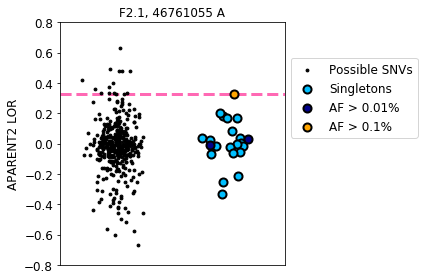

In [63]:
import seaborn as sns

gene_id = 'F2.1'
var_position = 46761055
var_position_hg38 = 46739505
var_nucleotide = 'A'

var_logodds = variant_df.query("gene_id == '" + gene_id + "' and var_position == " + str(var_position) + " and var_nucleotide == '" + str(var_nucleotide) + "'").iloc[0]['delta_logodds_0_205']

all_logodds = variant_df.query("gene_id == '" + gene_id + "' and (rel_var_position < 70 or rel_var_position >= 76)")['delta_logodds_0_205'].values

gnomad_logodds = f2_df_gnomad.query("gene_id == '" + gene_id + "'")['delta_logodds_0_205'].values
gnomad_logodds_singletons = f2_df_gnomad.query("gene_id == '" + gene_id + "' and AC == 1")['delta_logodds_0_205'].values
gnomad_logodds_0_0001 = f2_df_gnomad.query("gene_id == '" + gene_id + "' and AC > 1 and AF >= 0.0001 and AF < 0.001")['delta_logodds_0_205'].values
gnomad_logodds_0_001 = f2_df_gnomad.query("gene_id == '" + gene_id + "' and AC > 1 and AF >= 0.001 and AF < 0.01")['delta_logodds_0_205'].values
gnomad_logodds_0_01 = f2_df_gnomad.query("gene_id == '" + gene_id + "' and AC > 1 and AF >= 0.01 and AF < 0.1")['delta_logodds_0_205'].values
gnomad_logodds_0_1 = f2_df_gnomad.query("gene_id == '" + gene_id + "' and AC > 1 and AF >= 0.1")['delta_logodds_0_205'].values

f = plt.figure(figsize=(6, 4))

plt.scatter(np.random.normal(1., 0.1, size=(all_logodds.shape[0])), all_logodds, color='black', s=8, label='Possible SNVs')
if len(f2_df_gnomad.query("gene_id == '" + gene_id + "' and var_position_hg38 == " + str(var_position_hg38) + " and var_nucleotide == '" + str(var_nucleotide) + "'")) == 0 :
    plt.scatter([2.], np.array([var_logodds]), color='hotpink', s=65, edgecolor='black', linewidth=2, label='Observed SNV')

plt.axhline(y=np.array([var_logodds]), color='hotpink', linestyle='--', linewidth=3, zorder=0)

plt.scatter(np.random.normal(2., 0.1, size=(gnomad_logodds_singletons.shape[0])), gnomad_logodds_singletons, color='deepskyblue', s=65, edgecolor='black', linewidth=2, label='Singletons')
if gnomad_logodds_0_0001.shape[0] > 0 :
    plt.scatter(np.random.normal(2., 0.1, size=(gnomad_logodds_0_0001.shape[0])), gnomad_logodds_0_0001, color='darkblue', s=65, edgecolor='black', linewidth=2, label='AF > 0.01%')
if gnomad_logodds_0_001.shape[0] > 0 :
    plt.scatter(np.random.normal(2., 0.1, size=(gnomad_logodds_0_001.shape[0])), gnomad_logodds_0_001, color='orange', s=65, edgecolor='black', linewidth=2, label='AF > 0.1%')
if gnomad_logodds_0_01.shape[0] > 0 :
    plt.scatter(np.random.normal(2., 0.1, size=(gnomad_logodds_0_01.shape[0])), gnomad_logodds_0_01, color='darkviolet', s=65, edgecolor='black', linewidth=2, label='AF > 1%')
if gnomad_logodds_0_1.shape[0] > 0 :
    plt.scatter(np.random.normal(2., 0.1, size=(gnomad_logodds_0_1.shape[0])), gnomad_logodds_0_1, color='rebeccapurple', s=65, edgecolor='black', linewidth=2, label='AF > 10%')

plt.xlim(0.5, 2.5)
plt.ylim(-0.8, 0.8)

plt.yticks(fontsize=12)
plt.xticks([], [])

plt.ylabel("APARENT2 LOR", fontsize=12)

plt.title(gene_id + ", " + str(var_position) + " " + var_nucleotide, fontsize=12)

plt.legend(fontsize=12, loc='lower left', bbox_to_anchor=(1, 0.5))

plt.tight_layout()

plt.savefig("apa_gnomAD_example_" + gene_id + "_" + str(var_position) + "_" + str(var_nucleotide) + ".eps")
plt.savefig("apa_gnomAD_example_" + gene_id + "_" + str(var_position) + "_" + str(var_nucleotide) + ".png", dpi=300, transparent=True)

plt.show()


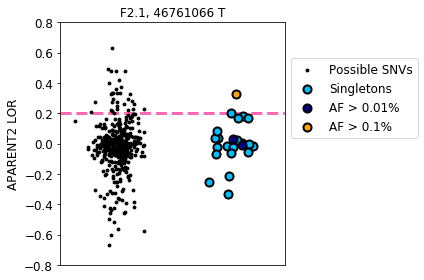

In [76]:
import seaborn as sns

gene_id = 'F2.1'
var_position = 46761066
var_position_hg38 = 46739516
var_nucleotide = 'T'

var_logodds = variant_df.query("gene_id == '" + gene_id + "' and var_position == " + str(var_position) + " and var_nucleotide == '" + str(var_nucleotide) + "'").iloc[0]['delta_logodds_0_205']

all_logodds = variant_df.query("gene_id == '" + gene_id + "' and (rel_var_position < 70 or rel_var_position >= 76)")['delta_logodds_0_205'].values

gnomad_logodds = f2_df_gnomad.query("gene_id == '" + gene_id + "'")['delta_logodds_0_205'].values
gnomad_logodds_singletons = f2_df_gnomad.query("gene_id == '" + gene_id + "' and AC == 1")['delta_logodds_0_205'].values
gnomad_logodds_0_0001 = f2_df_gnomad.query("gene_id == '" + gene_id + "' and AC > 1 and AF >= 0.0001 and AF < 0.001")['delta_logodds_0_205'].values
gnomad_logodds_0_001 = f2_df_gnomad.query("gene_id == '" + gene_id + "' and AC > 1 and AF >= 0.001 and AF < 0.01")['delta_logodds_0_205'].values
gnomad_logodds_0_01 = f2_df_gnomad.query("gene_id == '" + gene_id + "' and AC > 1 and AF >= 0.01 and AF < 0.1")['delta_logodds_0_205'].values
gnomad_logodds_0_1 = f2_df_gnomad.query("gene_id == '" + gene_id + "' and AC > 1 and AF >= 0.1")['delta_logodds_0_205'].values

f = plt.figure(figsize=(6, 4))

plt.scatter(np.random.normal(1., 0.1, size=(all_logodds.shape[0])), all_logodds, color='black', s=8, label='Possible SNVs')
if len(f2_df_gnomad.query("gene_id == '" + gene_id + "' and var_position_hg38 == " + str(var_position_hg38) + " and var_nucleotide == '" + str(var_nucleotide) + "'")) == 0 :
    plt.scatter([2.], np.array([var_logodds]), color='hotpink', s=65, edgecolor='black', linewidth=2, label='Observed SNV')

plt.axhline(y=np.array([var_logodds]), color='hotpink', linestyle='--', linewidth=3, zorder=0)

plt.scatter(np.random.normal(2., 0.1, size=(gnomad_logodds_singletons.shape[0])), gnomad_logodds_singletons, color='deepskyblue', s=65, edgecolor='black', linewidth=2, label='Singletons')
if gnomad_logodds_0_0001.shape[0] > 0 :
    plt.scatter(np.random.normal(2., 0.1, size=(gnomad_logodds_0_0001.shape[0])), gnomad_logodds_0_0001, color='darkblue', s=65, edgecolor='black', linewidth=2, label='AF > 0.01%')
if gnomad_logodds_0_001.shape[0] > 0 :
    plt.scatter(np.random.normal(2., 0.1, size=(gnomad_logodds_0_001.shape[0])), gnomad_logodds_0_001, color='orange', s=65, edgecolor='black', linewidth=2, label='AF > 0.1%')
if gnomad_logodds_0_01.shape[0] > 0 :
    plt.scatter(np.random.normal(2., 0.1, size=(gnomad_logodds_0_01.shape[0])), gnomad_logodds_0_01, color='darkviolet', s=65, edgecolor='black', linewidth=2, label='AF > 1%')
if gnomad_logodds_0_1.shape[0] > 0 :
    plt.scatter(np.random.normal(2., 0.1, size=(gnomad_logodds_0_1.shape[0])), gnomad_logodds_0_1, color='rebeccapurple', s=65, edgecolor='black', linewidth=2, label='AF > 10%')

plt.xlim(0.5, 2.5)
plt.ylim(-0.8, 0.8)

plt.yticks(fontsize=12)
plt.xticks([], [])

plt.ylabel("APARENT2 LOR", fontsize=12)

plt.title(gene_id + ", " + str(var_position) + " " + var_nucleotide, fontsize=12)

plt.legend(fontsize=12, loc='lower left', bbox_to_anchor=(1, 0.5))

plt.tight_layout()

plt.savefig("apa_gnomAD_example_" + gene_id + "_" + str(var_position) + "_" + str(var_nucleotide) + ".eps")
plt.savefig("apa_gnomAD_example_" + gene_id + "_" + str(var_position) + "_" + str(var_nucleotide) + ".png", dpi=300, transparent=True)

plt.show()


In [56]:
#Bin functional frequencies per gene and PAS

bin_min = -1.0
bin_max = 1.0
n_bins = 6

#bin_edges = np.linspace(bin_min, bin_max, n_bins+1)
bin_edges = np.array([-1.0, -0.4, -0.1, 0.0, 0.1, 0.4, 1.0])

singleton_dict = {}
af_0_0001_dict = {}
af_0_001_dict = {}
af_0_01_dict = {}
af_0_1_dict = {}

i = 0
for _, row in variant_df_gnomad.iterrows() :
    
    if i % 50000 == 0 :
        print("Processing variant " + str(i))
    
    gene_id = row['gene_id']
    
    if gene_id not in singleton_dict :
        singleton_dict[gene_id] = np.zeros(n_bins)
        af_0_0001_dict[gene_id] = np.zeros(n_bins)
        af_0_001_dict[gene_id] = np.zeros(n_bins)
        af_0_01_dict[gene_id] = np.zeros(n_bins)
        af_0_1_dict[gene_id] = np.zeros(n_bins)
    
    delta_logodds = row['delta_logodds_0_205']
    
    an = row['AN']
    ac = row['AC']
    af = row['AF']
    
    #Singletons or higher AF
    for bin_ix in range(n_bins) :
        if delta_logodds < bin_min :
            singleton_dict[gene_id][0] += 1
            break
        elif delta_logodds > bin_max :
            singleton_dict[gene_id][n_bins-1] += 1
            break
        elif delta_logodds >= bin_edges[bin_ix] and delta_logodds < bin_edges[bin_ix+1] :
            singleton_dict[gene_id][bin_ix] += 1
            break
    
    #Specific AF cutoffs
    if af >= 0.0001 :
        for bin_ix in range(n_bins) :
            if delta_logodds < bin_min :
                af_0_0001_dict[gene_id][0] += 1
                break
            elif delta_logodds > bin_max :
                af_0_0001_dict[gene_id][n_bins-1] += 1
                break
            elif delta_logodds >= bin_edges[bin_ix] and delta_logodds < bin_edges[bin_ix+1] :
                af_0_0001_dict[gene_id][bin_ix] += 1
                break
    if af >= 0.001 :
        for bin_ix in range(n_bins) :
            if delta_logodds < bin_min :
                af_0_001_dict[gene_id][0] += 1
                break
            elif delta_logodds > bin_max :
                af_0_001_dict[gene_id][n_bins-1] += 1
                break
            elif delta_logodds >= bin_edges[bin_ix] and delta_logodds < bin_edges[bin_ix+1] :
                af_0_001_dict[gene_id][bin_ix] += 1
                break
    if af >= 0.01 :
        for bin_ix in range(n_bins) :
            if delta_logodds < bin_min :
                af_0_01_dict[gene_id][0] += 1
                break
            elif delta_logodds > bin_max :
                af_0_01_dict[gene_id][n_bins-1] += 1
                break
            elif delta_logodds >= bin_edges[bin_ix] and delta_logodds < bin_edges[bin_ix+1] :
                af_0_01_dict[gene_id][bin_ix] += 1
                break
    if af >= 0.1 :
        for bin_ix in range(n_bins) :
            if delta_logodds < bin_min :
                af_0_1_dict[gene_id][0] += 1
                break
            elif delta_logodds > bin_max :
                af_0_1_dict[gene_id][n_bins-1] += 1
                break
            elif delta_logodds >= bin_edges[bin_ix] and delta_logodds < bin_edges[bin_ix+1] :
                af_0_1_dict[gene_id][bin_ix] += 1
                break
    
    i += 1


Processing variant 0
Processing variant 50000
Processing variant 100000
Processing variant 150000
Processing variant 200000
Processing variant 250000
Processing variant 300000
Processing variant 350000
Processing variant 400000
Processing variant 450000
Processing variant 500000
Processing variant 550000
Processing variant 600000
Processing variant 650000
Processing variant 700000
Processing variant 750000
Processing variant 800000
Processing variant 850000
Processing variant 900000
Processing variant 950000
Processing variant 1000000
Processing variant 1050000
Processing variant 1100000
Processing variant 1150000
Processing variant 1200000
Processing variant 1250000
Processing variant 1300000
Processing variant 1350000
Processing variant 1400000
Processing variant 1450000
Processing variant 1500000
Processing variant 1550000
Processing variant 1600000
Processing variant 1650000
Processing variant 1700000
Processing variant 1750000
Processing variant 1800000
Processing variant 1850000


In [57]:

def _inflate_gnomad_agg_df(pas_dict, n_bins, bin_edges) :

    df_dict = {}
    df_dict['gene'] = []
    df_dict['gene_id'] = []
    df_dict['chrom'] = []
    df_dict['pas_pos'] = []
    for bin_ix in range(n_bins) :
        df_dict["C_" + str(round(bin_edges[bin_ix], 2)) + "_to_" + str(round(bin_edges[bin_ix+1], 2))] = []

    #gene_id_df = polyadb_df.drop_duplicates(subset=['gene_id'], keep='first').copy()
    gene_id_df = polyadb_df.loc[~polyadb_df['chrom'].isin(['chr11', 'chr12', 'chr13', 'chr14', 'chr15'])].drop_duplicates(subset=['gene_id'], keep='first').copy()

    for _, row in gene_id_df.iterrows() :

        gene_id = row['gene_id']
        gene = row['gene']
        chrom = row['chrom']
        pas_pos = row['pas_pos']

        df_dict['gene_id'].append(gene_id)
        df_dict['gene'].append(gene)
        df_dict['chrom'].append(chrom)
        df_dict['pas_pos'].append(pas_pos)

        if gene_id in pas_dict :
            for bin_ix in range(n_bins) :
                df_dict["C_" + str(round(bin_edges[bin_ix], 2)) + "_to_" + str(round(bin_edges[bin_ix+1], 2))].append(
                    pas_dict[gene_id][bin_ix]
                )
        else :
            for bin_ix in range(n_bins) :
                df_dict["C_" + str(round(bin_edges[bin_ix], 2)) + "_to_" + str(round(bin_edges[bin_ix+1], 2))].append(
                    0.
                )

    pas_df_gnomad = pd.DataFrame(df_dict)
    
    pas_df_gnomad['lof_2'] = pas_df_gnomad['C_-1.0_to_-0.4']
    pas_df_gnomad['gof_2'] = pas_df_gnomad['C_0.4_to_1.0']
    pas_df_gnomad['any_2'] = pas_df_gnomad['lof_2'] + pas_df_gnomad['gof_2']
    pas_df_gnomad['lof_2_assym'] = pas_df_gnomad['lof_2'] - pas_df_gnomad['gof_2']

    pas_df_gnomad['lof'] = pas_df_gnomad['C_-1.0_to_-0.4'] + pas_df_gnomad['C_-0.4_to_-0.1']
    pas_df_gnomad['gof'] = pas_df_gnomad['C_0.4_to_1.0'] + pas_df_gnomad['C_0.1_to_0.4']
    pas_df_gnomad['any'] = pas_df_gnomad['lof'] + pas_df_gnomad['gof']
    pas_df_gnomad['lof_assym'] = pas_df_gnomad['lof'] - pas_df_gnomad['gof']
    
    return pas_df_gnomad

singleton_agg_df = _inflate_gnomad_agg_df(singleton_dict, n_bins, bin_edges)
af_0_0001_df = _inflate_gnomad_agg_df(af_0_0001_dict, n_bins, bin_edges)
af_0_001_df = _inflate_gnomad_agg_df(af_0_001_dict, n_bins, bin_edges)
af_0_01_df = _inflate_gnomad_agg_df(af_0_01_dict, n_bins, bin_edges)
af_0_1_df = _inflate_gnomad_agg_df(af_0_1_dict, n_bins, bin_edges)


In [76]:

singleton_agg_df = singleton_agg_df.join(polyadb_df[['gene_id', 'ratio']].set_index("gene_id"), on='gene_id', how='inner').copy().reset_index(drop=True)
af_0_0001_df = af_0_0001_df.join(polyadb_df[['gene_id', 'ratio']].set_index("gene_id"), on='gene_id', how='inner').copy().reset_index(drop=True)
af_0_001_df = af_0_001_df.join(polyadb_df[['gene_id', 'ratio']].set_index("gene_id"), on='gene_id', how='inner').copy().reset_index(drop=True)
af_0_01_df = af_0_01_df.join(polyadb_df[['gene_id', 'ratio']].set_index("gene_id"), on='gene_id', how='inner').copy().reset_index(drop=True)
af_0_1_df = af_0_1_df.join(polyadb_df[['gene_id', 'ratio']].set_index("gene_id"), on='gene_id', how='inner').copy().reset_index(drop=True)


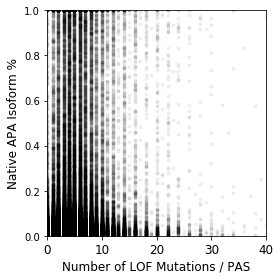

In [92]:

f = plt.figure(figsize=(4, 4))

plt.scatter(singleton_agg_df['lof'], singleton_agg_df['ratio'], s=8, color='black', alpha=0.05)

plt.xlim(0, 40)
plt.ylim(0, 1)

plt.xticks(fontsize=12)
plt.xticks(fontsize=12)

plt.xlabel("Number of LOF Mutations / PAS", fontsize=12)
plt.ylabel("Native APA Isoform %", fontsize=12)

plt.tight_layout()

plt.savefig("apa_gnomAD_n_lof_muts_vs_iso.eps")
plt.savefig("apa_gnomAD_n_lof_muts_vs_iso.png", dpi=300, transparent=True)

plt.show()


len(variant_df) = 43844676


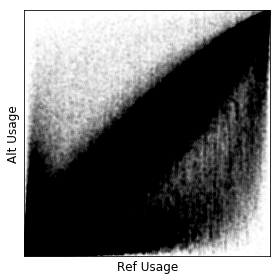

In [20]:
#Plot Ref/Alt usages

print("len(variant_df) = " + str(len(variant_df)))

ref_usage = np.copy(variant_df['native_usage'].values)
alt_usage = np.copy(variant_df['alt_usage'].values)

f = plt.figure(figsize=(4, 4))

plt.scatter(ref_usage, alt_usage, color='black', s=8, alpha=0.01)

plt.xlim(0, 1)
plt.ylim(0, 1)

plt.xticks([], [])
plt.yticks([], [])

plt.xlabel("Ref Usage", fontsize=12)
plt.ylabel("Alt Usage", fontsize=12)

plt.tight_layout()

plt.savefig("apa_polyADB_ref_alt_usage.png", dpi=600, transparent=False)

plt.show()


len(variant_df) = 43844676


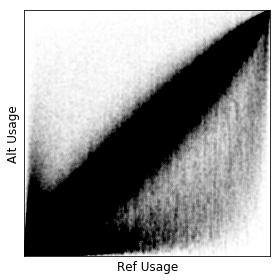

In [21]:
#Plot Ref/Alt usages

print("len(variant_df) = " + str(len(variant_df)))

ref_usage = np.copy(variant_df['native_usage'].values)
alt_usage = np.copy(variant_df['alt_usage'].values)

f = plt.figure(figsize=(4, 4))

plt.scatter(ref_usage, alt_usage, color='black', s=8, alpha=0.005)

plt.xlim(0, 1)
plt.ylim(0, 1)

plt.xticks([], [])
plt.yticks([], [])

plt.xlabel("Ref Usage", fontsize=12)
plt.ylabel("Alt Usage", fontsize=12)

plt.tight_layout()

plt.savefig("apa_polyADB_ref_alt_usage_less_alpha.png", dpi=600, transparent=False)

plt.show()


len(variant_df) = 43844676
len(variant_df_gnomad) = 2869862


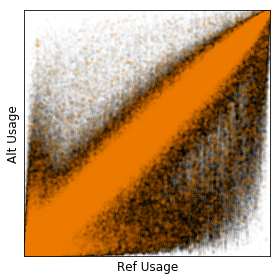

In [22]:
#Plot Ref/Alt usages, overlay gnomAD variants

print("len(variant_df) = " + str(len(variant_df)))
print("len(variant_df_gnomad) = " + str(len(variant_df_gnomad)))

ref_usage = np.copy(variant_df['native_usage'].values)
alt_usage = np.copy(variant_df['alt_usage'].values)

ref_usage_gnomad = np.copy(variant_df_gnomad['native_usage'].values)
alt_usage_gnomad = np.copy(variant_df_gnomad['alt_usage'].values)

f = plt.figure(figsize=(4, 4))

plt.scatter(ref_usage, alt_usage, color='black', s=8, alpha=0.01)
plt.scatter(ref_usage_gnomad, alt_usage_gnomad, color='darkorange', s=8, alpha=0.05)

plt.xlim(0, 1)
plt.ylim(0, 1)

plt.xticks([], [])
plt.yticks([], [])

plt.xlabel("Ref Usage", fontsize=12)
plt.ylabel("Alt Usage", fontsize=12)

plt.tight_layout()

plt.savefig("apa_polyADB_gnomAD_ref_alt_usage.png", dpi=600, transparent=False)

plt.show()


len(variant_df) = 43844676
len(variant_df_gnomad) = 2869862


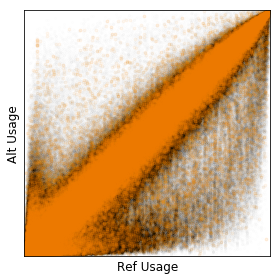

In [23]:
#Plot Ref/Alt usages, overlay gnomAD variants

print("len(variant_df) = " + str(len(variant_df)))
print("len(variant_df_gnomad) = " + str(len(variant_df_gnomad)))

ref_usage = np.copy(variant_df['native_usage'].values)
alt_usage = np.copy(variant_df['alt_usage'].values)

ref_usage_gnomad = np.copy(variant_df_gnomad['native_usage'].values)
alt_usage_gnomad = np.copy(variant_df_gnomad['alt_usage'].values)

f = plt.figure(figsize=(4, 4))

plt.scatter(ref_usage, alt_usage, color='black', s=8, alpha=0.005)
plt.scatter(ref_usage_gnomad, alt_usage_gnomad, color='darkorange', s=8, alpha=0.05)

plt.xlim(0, 1)
plt.ylim(0, 1)

plt.xticks([], [])
plt.yticks([], [])

plt.xlabel("Ref Usage", fontsize=12)
plt.ylabel("Alt Usage", fontsize=12)

plt.tight_layout()

plt.savefig("apa_polyADB_gnomAD_ref_alt_usage_less_alpha.png", dpi=600, transparent=False)

plt.show()


len(variant_df) = 43844676


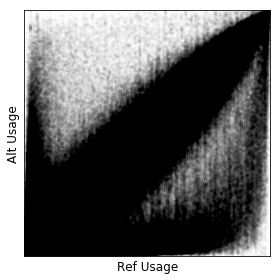

In [24]:
#Plot Ref/Alt usages

print("len(variant_df) = " + str(len(variant_df)))

ref_usage = np.copy(variant_df['native_usage'].values)
alt_usage = np.copy(variant_df['alt_usage_77_127'].values)

f = plt.figure(figsize=(4, 4))

plt.scatter(ref_usage, alt_usage, color='black', s=8, alpha=0.01)

plt.xlim(0, 1)
plt.ylim(0, 1)

plt.xticks([], [])
plt.yticks([], [])

plt.xlabel("Ref Usage", fontsize=12)
plt.ylabel("Alt Usage", fontsize=12)

plt.tight_layout()

plt.savefig("apa_polyADB_ref_alt_usage_77_127.png", dpi=600, transparent=False)

plt.show()


len(variant_df) = 43844676


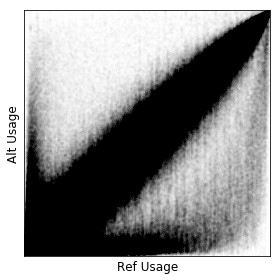

In [25]:
#Plot Ref/Alt usages

print("len(variant_df) = " + str(len(variant_df)))

ref_usage = np.copy(variant_df['native_usage'].values)
alt_usage = np.copy(variant_df['alt_usage_77_127'].values)

f = plt.figure(figsize=(4, 4))

plt.scatter(ref_usage, alt_usage, color='black', s=8, alpha=0.005)

plt.xlim(0, 1)
plt.ylim(0, 1)

plt.xticks([], [])
plt.yticks([], [])

plt.xlabel("Ref Usage", fontsize=12)
plt.ylabel("Alt Usage", fontsize=12)

plt.tight_layout()

plt.savefig("apa_polyADB_ref_alt_usage_77_127_less_alpha.png", dpi=600, transparent=False)

plt.show()


len(variant_df) = 43844676
len(variant_df_gnomad) = 2869862


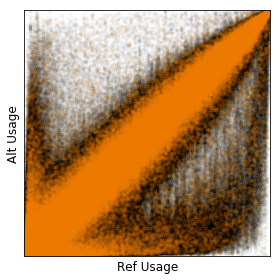

In [26]:
#Plot Ref/Alt usages, overlay gnomAD variants

print("len(variant_df) = " + str(len(variant_df)))
print("len(variant_df_gnomad) = " + str(len(variant_df_gnomad)))

ref_usage = np.copy(variant_df['native_usage'].values)
alt_usage = np.copy(variant_df['alt_usage_77_127'].values)

ref_usage_gnomad = np.copy(variant_df_gnomad['native_usage'].values)
alt_usage_gnomad = np.copy(variant_df_gnomad['alt_usage_77_127'].values)

f = plt.figure(figsize=(4, 4))

plt.scatter(ref_usage, alt_usage, color='black', s=8, alpha=0.01)
plt.scatter(ref_usage_gnomad, alt_usage_gnomad, color='darkorange', s=8, alpha=0.05)

plt.xlim(0, 1)
plt.ylim(0, 1)

plt.xticks([], [])
plt.yticks([], [])

plt.xlabel("Ref Usage", fontsize=12)
plt.ylabel("Alt Usage", fontsize=12)

plt.tight_layout()

plt.savefig("apa_polyADB_gnomAD_ref_alt_usage_77_127.png", dpi=600, transparent=False)

plt.show()


len(variant_df) = 43844676
len(variant_df_gnomad) = 2869862


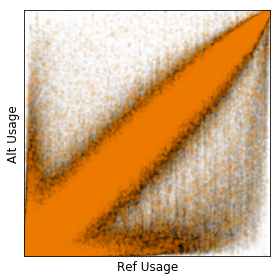

In [27]:
#Plot Ref/Alt usages, overlay gnomAD variants

print("len(variant_df) = " + str(len(variant_df)))
print("len(variant_df_gnomad) = " + str(len(variant_df_gnomad)))

ref_usage = np.copy(variant_df['native_usage'].values)
alt_usage = np.copy(variant_df['alt_usage_77_127'].values)

ref_usage_gnomad = np.copy(variant_df_gnomad['native_usage'].values)
alt_usage_gnomad = np.copy(variant_df_gnomad['alt_usage_77_127'].values)

f = plt.figure(figsize=(4, 4))

plt.scatter(ref_usage, alt_usage, color='black', s=8, alpha=0.005)
plt.scatter(ref_usage_gnomad, alt_usage_gnomad, color='darkorange', s=8, alpha=0.05)

plt.xlim(0, 1)
plt.ylim(0, 1)

plt.xticks([], [])
plt.yticks([], [])

plt.xlabel("Ref Usage", fontsize=12)
plt.ylabel("Alt Usage", fontsize=12)

plt.tight_layout()

plt.savefig("apa_polyADB_gnomAD_ref_alt_usage_77_127_less_alpha.png", dpi=600, transparent=False)

plt.show()


In [15]:
#Find variants not present in gnomAD

variant_df_not_gnomad = variant_df.join(gnomad_df[["gnomad_join_id", "AC"]].set_index("gnomad_join_id"), on='gnomad_join_id', how='left').copy().reset_index(drop=True)
variant_df_not_gnomad = variant_df_not_gnomad.loc[variant_df_not_gnomad["AC"].isnull()].copy().reset_index(drop=True)


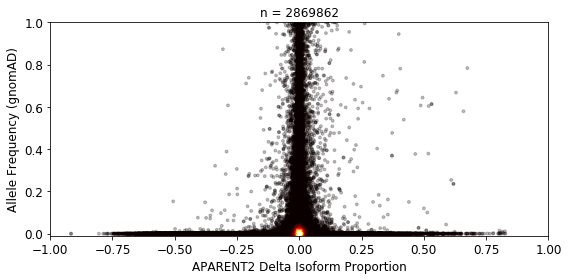

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

n_samples_for_kde = 1000

values = np.vstack([variant_df_gnomad['delta_usage'].values[None, :], variant_df_gnomad['AF'].values[None, :]])

sample_index = np.arange(values.shape[1])
np.random.shuffle(sample_index)

kernel = stats.gaussian_kde(values[:, sample_index[:n_samples_for_kde]])(values)

fig = plt.figure(figsize=(8, 4))

plt.scatter(
    variant_df_gnomad['delta_usage'].values,
    variant_df_gnomad['AF'].values,
    c=kernel,
    cmap="hot",
    s=8,
    alpha=0.25
)

#l1 = plt.axvline(x=-0.15, linewidth=3, color='lightcoral', label='|LOR| > 0.15')
#plt.axvline(x=0.15, linewidth=3, color='lightcoral')

plt.xlim(-1., 1.)
plt.ylim(-0.01, 1.)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.xlabel("APARENT2 Delta Isoform Proportion", fontsize=12)
plt.ylabel("Allele Frequency (gnomAD)", fontsize=12)

plt.title("n = " + str(len(variant_df_gnomad)), fontsize=12)

#plt.legend(handles=[l1], fontsize=12)

plt.tight_layout()

plt.savefig("apa_gnomAD_delta_usage_vs_AF.eps")
plt.savefig("apa_gnomAD_delta_usage_vs_AF.png", dpi=600, transparent=True)

plt.show()


Wilcoxon statistic = 7.8728
P-value = 3.4673817386286573e-15
n1 / n2 = 819153 / 63405
AF threshold = 0.001


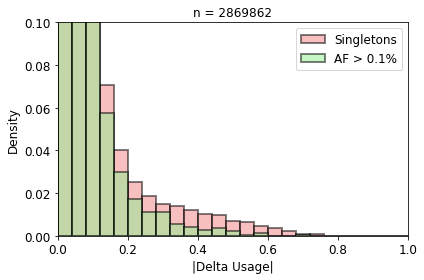

In [17]:
from scipy.stats import ttest_ind, ranksums

f = plt.figure(figsize=(6, 4))

x = np.abs(variant_df_gnomad.query("delta_usage < 0.")['delta_usage'])
y = variant_df_gnomad.query("delta_usage < 0.")['AF']
ac = variant_df_gnomad.query("delta_usage < 0.")['AC']

ac_thresh_low = 1
af_thresh_high = 0.001
x_thresh = 1.
x_min = 0.

x1 = x[(ac <= ac_thresh_low) & (x <= x_thresh)]
x2 = x[(y > af_thresh_high) & (x <= x_thresh)]

s, p = ranksums(x1, x2)

print("Wilcoxon statistic = " + str(round(s, 4)))
print("P-value = " + str(p))
print("n1 / n2 = " + str(x1.shape[0]) + " / " + str(x2.shape[0]))
print("AF threshold = " + str(round(af_thresh_high, 4)))

x1_hist, bin_edges = np.histogram(x1, range=(x_min, x_thresh), bins=25, density=True)
x2_hist, _ = np.histogram(x2, range=(x_min, x_thresh), bins=25, density=True)

bin_width = bin_edges[1] - bin_edges[0]

plt.bar(bin_edges[:-1] + bin_width/2., x1_hist, width=bin_width, color='lightcoral', alpha=0.5, linewidth=2, edgecolor='black', label='Singletons')
plt.bar(bin_edges[:-1] + bin_width/2., x2_hist, width=bin_width, color='lightgreen', alpha=0.5, linewidth=2, edgecolor='black', label='AF > ' + str(af_thresh_high * 100) + '%')

plt.xlim(x_min, x_thresh)
plt.ylim(0., 0.1)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.xlabel("|Delta Usage|", fontsize=12)
plt.ylabel("Density", fontsize=12)

plt.title("n = " + str(len(variant_df_gnomad)), fontsize=12)

plt.legend(fontsize=12)

plt.tight_layout()

plt.savefig("apa_gnomAD_delta_usage_vs_AF_histo_only_neg.eps")
plt.savefig("apa_gnomAD_delta_usage_vs_AF_histo_only_neg.png", dpi=300, transparent=True)

plt.show()


Wilcoxon statistic = -18.4983
P-value = 2.1300978337640108e-76
n1 / n2 = 1515940 / 122847
AF threshold = 0.001


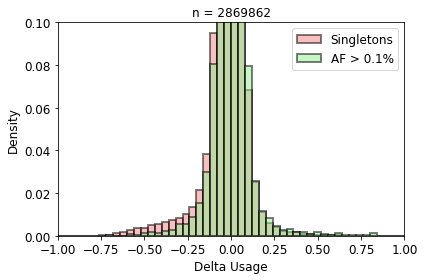

In [18]:
from scipy.stats import ttest_ind, ranksums

f = plt.figure(figsize=(6, 4))

x = variant_df_gnomad['delta_usage']
y = variant_df_gnomad['AF']
ac = variant_df_gnomad['AC']

ac_thresh_low = 1
af_thresh_high = 0.001
x_thresh = 1.
x_min = -x_thresh

x1 = x[(ac <= ac_thresh_low) & (x <= x_thresh)]
x2 = x[(y > af_thresh_high) & (x <= x_thresh)]

s, p = ranksums(x1, x2)

print("Wilcoxon statistic = " + str(round(s, 4)))
print("P-value = " + str(p))
print("n1 / n2 = " + str(x1.shape[0]) + " / " + str(x2.shape[0]))
print("AF threshold = " + str(round(af_thresh_high, 4)))

x1_hist, bin_edges = np.histogram(x1, range=(x_min, x_thresh), bins=50, density=True)
x2_hist, _ = np.histogram(x2, range=(x_min, x_thresh), bins=50, density=True)

bin_width = bin_edges[1] - bin_edges[0]

plt.bar(bin_edges[:-1] + bin_width/2., x1_hist, width=bin_width, color='lightcoral', alpha=0.5, linewidth=2, edgecolor='black', label='Singletons')
plt.bar(bin_edges[:-1] + bin_width/2., x2_hist, width=bin_width, color='lightgreen', alpha=0.5, linewidth=2, edgecolor='black', label='AF > ' + str(af_thresh_high * 100) + '%')

plt.xlim(x_min, x_thresh)
plt.ylim(0., 0.1)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.xlabel("Delta Usage", fontsize=12)
plt.ylabel("Density", fontsize=12)

plt.title("n = " + str(len(variant_df_gnomad)), fontsize=12)

plt.legend(fontsize=12)

plt.tight_layout()

plt.savefig("apa_gnomAD_delta_usage_vs_AF_histo.eps")
plt.savefig("apa_gnomAD_delta_usage_vs_AF_histo.png", dpi=300, transparent=True)

plt.show()


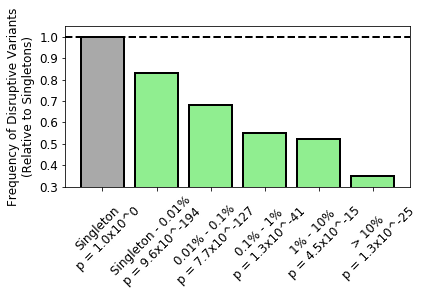

In [25]:
#Calculate statistics in intervals of AF

x = variant_df_gnomad['delta_usage']
y = variant_df_gnomad['AF']
ac = variant_df_gnomad['AC']

ac_thresh_low = 1
x_thresh_low = -0.15

x_singleton = x[ac <= ac_thresh_low]
x_singleton_0_0001 = x[(ac > ac_thresh_low) & (y <= 0.0001)]
x_0_0001_0_001 = x[(y > 0.0001) & (y <= 0.001)]
x_0_001_0_01 = x[(y > 0.001) & (y <= 0.01)]
x_0_01_0_1 = x[(y > 0.01) & (y <= 0.1)]
x_0_1 = x[y > 0.1]

_, p_singleton_0_0001 = ranksums(x_singleton, x_singleton_0_0001)
_, p_0_0001_0_001 = ranksums(x_singleton, x_0_0001_0_001)
_, p_0_001_0_01 = ranksums(x_singleton, x_0_001_0_01)
_, p_0_01_0_1 = ranksums(x_singleton, x_0_01_0_1)
_, p_0_1 = ranksums(x_singleton, x_0_1)

f_singleton = np.sum(x_singleton < x_thresh_low) / x_singleton.shape[0]
f_singleton_0_0001 = np.sum(x_singleton_0_0001 < x_thresh_low) / x_singleton_0_0001.shape[0]
f_0_0001_0_001 = np.sum(x_0_0001_0_001 < x_thresh_low) / x_0_0001_0_001.shape[0]
f_0_001_0_01 = np.sum(x_0_001_0_01 < x_thresh_low) / x_0_001_0_01.shape[0]
f_0_01_0_1 = np.sum(x_0_01_0_1 < x_thresh_low) / x_0_01_0_1.shape[0]
f_0_1 = np.sum(x_0_1 < x_thresh_low) / x_0_1.shape[0]

r_singleton_0_0001 = f_singleton_0_0001 / f_singleton
r_0_0001_0_001 = f_0_0001_0_001 / f_singleton
r_0_001_0_01 = f_0_001_0_01 / f_singleton
r_0_01_0_1 = f_0_01_0_1 / f_singleton
r_0_1 = f_0_1 / f_singleton

ps = np.array([1., p_singleton_0_0001, p_0_0001_0_001, p_0_001_0_01, p_0_01_0_1, p_0_1])
fs = np.array([1., r_singleton_0_0001, r_0_0001_0_001, r_0_001_0_01, r_0_01_0_1, r_0_1])

f = plt.figure(figsize=(6, 4))

plt.bar([0], [fs[0]], color='darkgray', linewidth=2, edgecolor='black')
plt.bar(np.arange(fs.shape[0]-1)+1, fs[1:], color='lightgreen', linewidth=2, edgecolor='black')

plt.axhline(y=1.0, linewidth=2, linestyle='--', color='black')

def _format_p(p) :
    return str(p)[:3] + "x10^" + str(int(np.log(p) / np.log(10.)))

plt.xticks(
    np.arange(fs.shape[0]), [
        "Singleton\np = " + _format_p(ps[0]),
        "Singleton - 0.01%\np = " + _format_p(ps[1]),
        "0.01% - 0.1%\np = " + _format_p(ps[2]),
        "0.1% - 1%\np = " + _format_p(ps[3]),
        "1% - 10%\np = " + _format_p(ps[4]),
        "> 10%\np = " + _format_p(ps[5]),
    ], fontsize=12, rotation=45
)

plt.yticks(fontsize=12)

plt.ylabel("Frequency of Disruptive Variants\n(Relative to Singletons)", fontsize=12)

plt.ylim(0.3, 1.05)

plt.tight_layout()

plt.savefig("apa_gnomAD_disruptive_frequency.eps")
plt.savefig("apa_gnomAD_disruptive_frequency.png", transparent=True, dpi=300)

plt.show()


n = 2869862


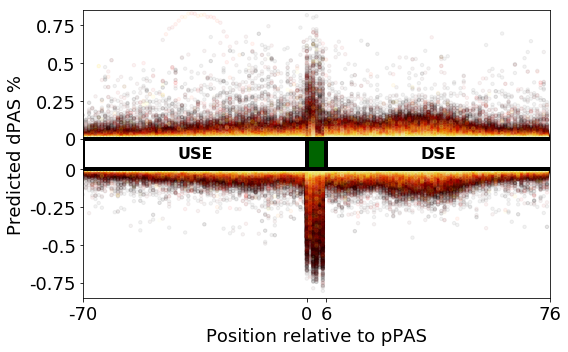

In [20]:
import matplotlib.cm as cm
import matplotlib.colors as colors

import matplotlib as mpl
from matplotlib.text import TextPath
from matplotlib.patches import PathPatch, Rectangle
from matplotlib.font_manager import FontProperties
from matplotlib import gridspec
from matplotlib.ticker import FormatStrFormatter

from scipy.stats import spearmanr, ttest_ind

df = variant_df_gnomad.copy()

fig_name = 'apa_gnomAD_delta_usage_pos_scatter'

snv_pos_column = 'rel_var_position'
pred_column = 'delta_usage'
p_val_column = 'AF'

sort_pred = True
show_stats = False
color_by_p_val = True

fig = plt.figure(figsize=(8, 5))

annotation_height = 0.2

border_eta = 0.00

dot_size=12
dot_alpha=0.05

snv_pos = np.ravel(df[snv_pos_column].values) - 70
p_val_true = np.log(np.ravel(df[p_val_column].values)) / np.log(10.)
delta_logodds_pred = np.ravel(df[pred_column].values)

vmin = np.quantile(p_val_true, q=0.50)
vmax = np.quantile(p_val_true, q=1.00)

n_points = len(df)

if sort_pred :
    sort_index = np.argsort(np.abs(p_val_true))[::-1]
    snv_pos = snv_pos[sort_index]
    p_val_true = p_val_true[sort_index]
    delta_logodds_pred = delta_logodds_pred[sort_index]

delta_logodds_pred[delta_logodds_pred < 0.0] -= annotation_height
ax = plt.gca()
ax.add_patch(Rectangle((-70 + border_eta, -annotation_height + border_eta), 70 - 2.*border_eta, annotation_height - 2.*border_eta, fill=True, facecolor='white', edgecolor='black', lw=4))
ax.add_patch(Rectangle((0 + border_eta, -annotation_height + border_eta), 6 - 2.*border_eta, annotation_height - 2.*border_eta, fill=True, facecolor='darkgreen', edgecolor='black', lw=4))
ax.add_patch(Rectangle((6 + border_eta, -annotation_height + border_eta), 76 - 2.*border_eta, annotation_height - 2.*border_eta, fill=True, facecolor='white', edgecolor='black', lw=4))

use_start = -70
use_end = 0
if use_end - use_start > 10 :
    ax.text(use_start + (use_end - use_start) / 2., -annotation_height/2., 'USE', horizontalalignment='center', verticalalignment='center', color='black', fontsize=16, weight="bold")

dse_start = 6
dse_end = 76
if dse_end - dse_start > 10 :
    ax.text(dse_start + (dse_end - dse_start) / 2., -annotation_height/2., 'DSE', horizontalalignment='center', verticalalignment='center', color='black', fontsize=16, weight="bold")

if color_by_p_val :
    plt.scatter(snv_pos, delta_logodds_pred, c=p_val_true, cmap="hot", vmin=vmin, vmax=vmax, alpha=dot_alpha, s=dot_size)
else :
    plt.scatter(snv_pos, delta_logodds_pred, c='black', vmin=vmin, vmax=vmax, alpha=dot_alpha, s=dot_size)

annot_text = 'n = ' + str(n_points)

print(annot_text)

if show_stats :
    ax = plt.gca()
    ax.text(0.95, 0.90, annot_text, horizontalalignment='right', verticalalignment='bottom', transform=ax.transAxes, color='black', fontsize=16, weight="bold")

plt.xticks([use_start, 0, 6, dse_end], [use_start, 0, 6, dse_end], fontsize=18)
plt.yticks([-0.75-0.2, -0.5-0.2, -0.25-0.2, -0.2, 0, 0.25, 0.5, 0.75], [-0.75, -0.5, -0.25, 0, 0, 0.25, 0.5, 0.75], fontsize=18)

plt.xlabel('Position relative to pPAS', fontsize=18)
plt.ylabel('Predicted dPAS %', fontsize=18)

plt.xlim(use_start, dse_end)
plt.ylim(-0.85-0.2, 0.85)

plt.tight_layout()

if fig_name is not None :
    plt.savefig(fig_name + '.png', dpi=600, transparent=True)
    plt.savefig(fig_name + '.eps')

plt.show()


n = 2869862


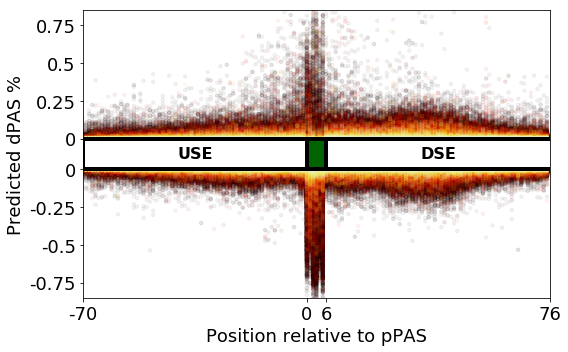

In [21]:
import matplotlib.cm as cm
import matplotlib.colors as colors

import matplotlib as mpl
from matplotlib.text import TextPath
from matplotlib.patches import PathPatch, Rectangle
from matplotlib.font_manager import FontProperties
from matplotlib import gridspec
from matplotlib.ticker import FormatStrFormatter

from scipy.stats import spearmanr, ttest_ind

df = variant_df_gnomad.copy()

fig_name = 'apa_gnomAD_delta_usage_77_127_pos_scatter'

snv_pos_column = 'rel_var_position'
pred_column = 'delta_usage_77_127'
p_val_column = 'AF'

sort_pred = True
show_stats = False
color_by_p_val = True

fig = plt.figure(figsize=(8, 5))

annotation_height = 0.2

border_eta = 0.00

dot_size=12
dot_alpha=0.05

snv_pos = np.ravel(df[snv_pos_column].values) - 70
p_val_true = np.log(np.ravel(df[p_val_column].values)) / np.log(10.)
delta_logodds_pred = np.ravel(df[pred_column].values)

vmin = np.quantile(p_val_true, q=0.50)
vmax = np.quantile(p_val_true, q=1.00)

n_points = len(df)

if sort_pred :
    sort_index = np.argsort(np.abs(p_val_true))[::-1]
    snv_pos = snv_pos[sort_index]
    p_val_true = p_val_true[sort_index]
    delta_logodds_pred = delta_logodds_pred[sort_index]

delta_logodds_pred[delta_logodds_pred < 0.0] -= annotation_height
ax = plt.gca()
ax.add_patch(Rectangle((-70 + border_eta, -annotation_height + border_eta), 70 - 2.*border_eta, annotation_height - 2.*border_eta, fill=True, facecolor='white', edgecolor='black', lw=4))
ax.add_patch(Rectangle((0 + border_eta, -annotation_height + border_eta), 6 - 2.*border_eta, annotation_height - 2.*border_eta, fill=True, facecolor='darkgreen', edgecolor='black', lw=4))
ax.add_patch(Rectangle((6 + border_eta, -annotation_height + border_eta), 76 - 2.*border_eta, annotation_height - 2.*border_eta, fill=True, facecolor='white', edgecolor='black', lw=4))

use_start = -70
use_end = 0
if use_end - use_start > 10 :
    ax.text(use_start + (use_end - use_start) / 2., -annotation_height/2., 'USE', horizontalalignment='center', verticalalignment='center', color='black', fontsize=16, weight="bold")

dse_start = 6
dse_end = 76
if dse_end - dse_start > 10 :
    ax.text(dse_start + (dse_end - dse_start) / 2., -annotation_height/2., 'DSE', horizontalalignment='center', verticalalignment='center', color='black', fontsize=16, weight="bold")

if color_by_p_val :
    plt.scatter(snv_pos, delta_logodds_pred, c=p_val_true, cmap="hot", vmin=vmin, vmax=vmax, alpha=dot_alpha, s=dot_size)
else :
    plt.scatter(snv_pos, delta_logodds_pred, c='black', vmin=vmin, vmax=vmax, alpha=dot_alpha, s=dot_size)

annot_text = 'n = ' + str(n_points)

print(annot_text)

if show_stats :
    ax = plt.gca()
    ax.text(0.95, 0.90, annot_text, horizontalalignment='right', verticalalignment='bottom', transform=ax.transAxes, color='black', fontsize=16, weight="bold")

plt.xticks([use_start, 0, 6, dse_end], [use_start, 0, 6, dse_end], fontsize=18)
plt.yticks([-0.75-0.2, -0.5-0.2, -0.25-0.2, -0.2, 0, 0.25, 0.5, 0.75], [-0.75, -0.5, -0.25, 0, 0, 0.25, 0.5, 0.75], fontsize=18)

plt.xlabel('Position relative to pPAS', fontsize=18)
plt.ylabel('Predicted dPAS %', fontsize=18)

plt.xlim(use_start, dse_end)
plt.ylim(-0.85-0.2, 0.85)

plt.tight_layout()

if fig_name is not None :
    plt.savefig(fig_name + '.png', dpi=600, transparent=True)
    plt.savefig(fig_name + '.eps')

plt.show()


Wilcoxon statistic = -52.601
P-value = 0.0
n1 / n2 = 1515940 / 1515940
AF threshold = 0.001


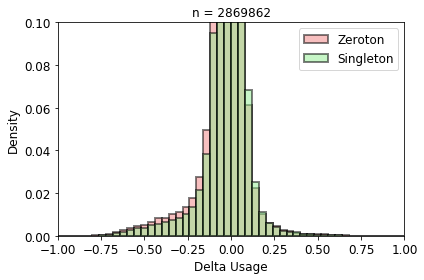

In [22]:
from scipy.stats import ttest_ind, ranksums

f = plt.figure(figsize=(6, 4))

x1 = variant_df_not_gnomad['delta_usage']
x2 = variant_df_gnomad['delta_usage']
y = variant_df_gnomad['AF']
ac = variant_df_gnomad['AC']

ac_thresh_low = 1
af_thresh_high = 0.001
x_thresh = 1.
x_min = -x_thresh

x2 = x2[(ac <= ac_thresh_low)]

n_samples_gnomad = x2.shape[0]
x1 = x1[x1 <= x_thresh]
keep_index = np.arange(x1.shape[0], dtype=np.int)
np.random.shuffle(keep_index)
keep_index = keep_index[:n_samples_gnomad]
x1 = x1[keep_index]

s, p = ranksums(x1, x2)

print("Wilcoxon statistic = " + str(round(s, 4)))
print("P-value = " + str(p))
print("n1 / n2 = " + str(x1.shape[0]) + " / " + str(x2.shape[0]))
print("AF threshold = " + str(round(af_thresh_high, 4)))

x1_hist, bin_edges = np.histogram(x1, range=(x_min, x_thresh), bins=50, density=True)
x2_hist, _ = np.histogram(x2, range=(x_min, x_thresh), bins=50, density=True)

bin_width = bin_edges[1] - bin_edges[0]

plt.bar(bin_edges[:-1] + bin_width/2., x1_hist, width=bin_width, color='lightcoral', alpha=0.5, linewidth=2, edgecolor='black', label='Zeroton')
plt.bar(bin_edges[:-1] + bin_width/2., x2_hist, width=bin_width, color='lightgreen', alpha=0.5, linewidth=2, edgecolor='black', label='Singleton')

plt.xlim(x_min, x_thresh)
plt.ylim(0., 0.1)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.xlabel("Delta Usage", fontsize=12)
plt.ylabel("Density", fontsize=12)

plt.title("n = " + str(len(variant_df_gnomad)), fontsize=12)

plt.legend(fontsize=12)

plt.tight_layout()

plt.savefig("apa_gnomAD_delta_usage_vs_AF_histo_z_vs_s.eps")
plt.savefig("apa_gnomAD_delta_usage_vs_AF_histo_z_vs_s.png", dpi=300, transparent=True)

plt.show()


Wilcoxon statistic = -28.7732
P-value = 4.646893270878792e-182
n1 / n2 = 122847 / 122847
AF threshold = 0.001


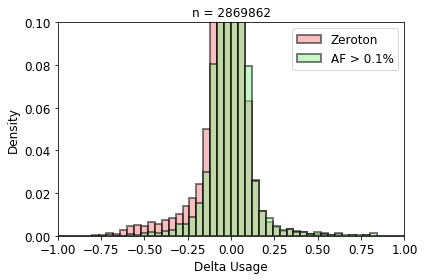

In [23]:
from scipy.stats import ttest_ind, ranksums

f = plt.figure(figsize=(6, 4))

x1 = variant_df_not_gnomad['delta_usage']
x2 = variant_df_gnomad['delta_usage']
y = variant_df_gnomad['AF']
ac = variant_df_gnomad['AC']

ac_thresh_low = 1
af_thresh_high = 0.001
x_thresh = 1.
x_min = -x_thresh

x2 = x2[(y > af_thresh_high) & (x2 <= x_thresh)]

n_samples_gnomad = x2.shape[0]
x1 = x1[x1 <= x_thresh]
keep_index = np.arange(x1.shape[0], dtype=np.int)
np.random.shuffle(keep_index)
keep_index = keep_index[:n_samples_gnomad]
x1 = x1[keep_index]

s, p = ranksums(x1, x2)

print("Wilcoxon statistic = " + str(round(s, 4)))
print("P-value = " + str(p))
print("n1 / n2 = " + str(x1.shape[0]) + " / " + str(x2.shape[0]))
print("AF threshold = " + str(round(af_thresh_high, 4)))

x1_hist, bin_edges = np.histogram(x1, range=(x_min, x_thresh), bins=50, density=True)
x2_hist, _ = np.histogram(x2, range=(x_min, x_thresh), bins=50, density=True)

bin_width = bin_edges[1] - bin_edges[0]

plt.bar(bin_edges[:-1] + bin_width/2., x1_hist, width=bin_width, color='lightcoral', alpha=0.5, linewidth=2, edgecolor='black', label='Zeroton')
plt.bar(bin_edges[:-1] + bin_width/2., x2_hist, width=bin_width, color='lightgreen', alpha=0.5, linewidth=2, edgecolor='black', label='AF > ' + str(af_thresh_high * 100) + '%')

plt.xlim(x_min, x_thresh)
plt.ylim(0., 0.1)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.xlabel("Delta Usage", fontsize=12)
plt.ylabel("Density", fontsize=12)

plt.title("n = " + str(len(variant_df_gnomad)), fontsize=12)

plt.legend(fontsize=12)

plt.tight_layout()

plt.savefig("apa_gnomAD_delta_usage_vs_AF_histo_z_vs_af_01.eps")
plt.savefig("apa_gnomAD_delta_usage_vs_AF_histo_z_vs_af_01.png", dpi=300, transparent=True)

plt.show()


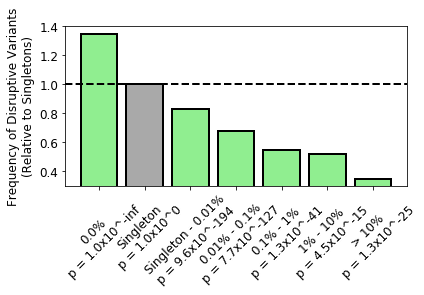

In [26]:
#Calculate statistics in intervals of AF (include 'Zerotons')

x_not_gnomad = variant_df_not_gnomad['delta_usage']
x = variant_df_gnomad['delta_usage']
y = variant_df_gnomad['AF']
ac = variant_df_gnomad['AC']

ac_thresh_low = 1
x_thresh_low = -0.15

x_zeroton = x_not_gnomad
x_singleton = x[ac <= ac_thresh_low]
x_singleton_0_0001 = x[(ac > ac_thresh_low) & (y <= 0.0001)]
x_0_0001_0_001 = x[(y > 0.0001) & (y <= 0.001)]
x_0_001_0_01 = x[(y > 0.001) & (y <= 0.01)]
x_0_01_0_1 = x[(y > 0.01) & (y <= 0.1)]
x_0_1 = x[y > 0.1]

#Sub-sample zerotons
n_samples_singleton = x_singleton.shape[0]
keep_index = np.arange(x_zeroton.shape[0], dtype=np.int)
np.random.shuffle(keep_index)
keep_index = keep_index[:n_samples_singleton]
x_zeroton = x_zeroton[keep_index]

_, p_zeroton = ranksums(x_zeroton, x_singleton)
_, p_singleton_0_0001 = ranksums(x_singleton, x_singleton_0_0001)
_, p_0_0001_0_001 = ranksums(x_singleton, x_0_0001_0_001)
_, p_0_001_0_01 = ranksums(x_singleton, x_0_001_0_01)
_, p_0_01_0_1 = ranksums(x_singleton, x_0_01_0_1)
_, p_0_1 = ranksums(x_singleton, x_0_1)

f_zeroton = np.sum(x_zeroton < x_thresh_low) / x_zeroton.shape[0]
f_singleton = np.sum(x_singleton < x_thresh_low) / x_singleton.shape[0]
f_singleton_0_0001 = np.sum(x_singleton_0_0001 < x_thresh_low) / x_singleton_0_0001.shape[0]
f_0_0001_0_001 = np.sum(x_0_0001_0_001 < x_thresh_low) / x_0_0001_0_001.shape[0]
f_0_001_0_01 = np.sum(x_0_001_0_01 < x_thresh_low) / x_0_001_0_01.shape[0]
f_0_01_0_1 = np.sum(x_0_01_0_1 < x_thresh_low) / x_0_01_0_1.shape[0]
f_0_1 = np.sum(x_0_1 < x_thresh_low) / x_0_1.shape[0]

r_zeroton = f_zeroton / f_singleton
r_singleton_0_0001 = f_singleton_0_0001 / f_singleton
r_0_0001_0_001 = f_0_0001_0_001 / f_singleton
r_0_001_0_01 = f_0_001_0_01 / f_singleton
r_0_01_0_1 = f_0_01_0_1 / f_singleton
r_0_1 = f_0_1 / f_singleton

ps = np.array([p_zeroton, 1., p_singleton_0_0001, p_0_0001_0_001, p_0_001_0_01, p_0_01_0_1, p_0_1])
fs = np.array([r_zeroton, 1., r_singleton_0_0001, r_0_0001_0_001, r_0_001_0_01, r_0_01_0_1, r_0_1])

f = plt.figure(figsize=(6, 4))

plt.bar([1], [fs[1]], color='darkgray', linewidth=2, edgecolor='black')
plt.bar([0] + (np.arange(fs.shape[0]-2)+2).tolist(), [fs[0]] + fs[2:].tolist(), color='lightgreen', linewidth=2, edgecolor='black')

plt.axhline(y=1.0, linewidth=2, linestyle='--', color='black')

def _format_p(p) :
    if p == 0. :
        return "1.0x10^-inf"
    
    return str(p)[:3] + "x10^" + str(int(np.log(p) / np.log(10.)))

plt.xticks(
    np.arange(fs.shape[0]), [
        "0.0%\np = " + _format_p(ps[0]),
        "Singleton\np = " + _format_p(ps[1]),
        "Singleton - 0.01%\np = " + _format_p(ps[2]),
        "0.01% - 0.1%\np = " + _format_p(ps[3]),
        "0.1% - 1%\np = " + _format_p(ps[4]),
        "1% - 10%\np = " + _format_p(ps[5]),
        "> 10%\np = " + _format_p(ps[6]),
    ], fontsize=12, rotation=45
)

plt.yticks(fontsize=12)

plt.ylabel("Frequency of Disruptive Variants\n(Relative to Singletons)", fontsize=12)

plt.ylim(0.3, 1.4)

plt.tight_layout()

plt.savefig("apa_gnomAD_disruptive_frequency_w_zeroton.eps")
plt.savefig("apa_gnomAD_disruptive_frequency_w_zeroton.png", transparent=True, dpi=300)

plt.show()
